<a href="https://colab.research.google.com/github/Ajjme/Feedback_Systems/blob/main/Climate_Action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
import matplotlib.pyplot as plt
import math
import copy

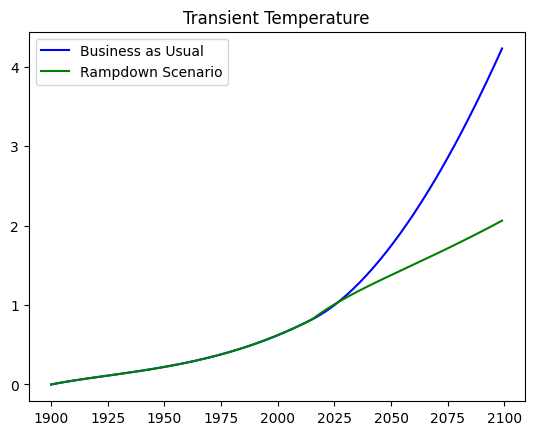

In [1]:

# Initialize Constants
timestep = 1
aerosol_Wm2_now = -0.75 			# Watts/m2
eq_co2 = 280.0						# ppm
initial_co2 = 290.0					# ppm
exp_growth_rate = 0.0225			# ppm / year
drawdown_rate = 0.01 				# ppm / year
climate_sensitivity_2x = 3 			# degrees C for doubling CO2
									# T_eq change for doubling CO2, radiative forcing of 4 Watts/m2
watts_m2_2x = 4
climate_sensitivity_watts_m2 \
	= climate_sensitivity_2x / watts_m2_2x 	# T_eq change per Watts/m2 of forcing

t_response_time = 20				# year; fudge combination of faster eq. of surface, slower eq. of ocean
years = range(1900, 2100)			# list of years

## Business-as-usual Stage
biz_pCO2 = numpy.zeros(len(years))
biz_pCO2[0] = initial_co2
biz_pCO2_diffs = numpy.zeros(len(years))
biz_pCO2_RF = numpy.zeros(len(years))
biz_total_RF = numpy.zeros(len(years))
biz_T_eq = numpy.zeros(len(years))
biz_T_trans = numpy.zeros(len(years))
biz_masking_RF = numpy.zeros(len(years))

# Compute the CO2 and RF forcing from the CO2
for t in range(timestep, len(years), timestep):
	biz_pCO2[t] = eq_co2 + (biz_pCO2[t - timestep] - eq_co2) * (1 + exp_growth_rate * timestep)
	biz_pCO2_diffs[t] = (biz_pCO2[t] - biz_pCO2[t - timestep]) / timestep
	biz_pCO2_RF[t] = watts_m2_2x * (math.log(biz_pCO2[t] / eq_co2) / math.log(2.0))
year_2015_index = years.index(2015 + timestep)

# Compute the aerosol rate
B = aerosol_Wm2_now / \
	((biz_pCO2[year_2015_index] - biz_pCO2[year_2015_index - timestep] ) / timestep)

# Compute the total RF, T_eq and T_trans;
for t in range(timestep, len(years), timestep):
	# Calculate the RF by masking (by multiplying the incremental CO2 change in
	# any given timestep by the coefficient B
	biz_masking_RF[t] = max( biz_pCO2_diffs[t] * B, aerosol_Wm2_now )
	# Calculate the total RF = from CO2 and from masking
	biz_total_RF[t] = biz_pCO2_RF[t] + biz_masking_RF[t]
	# Calculate the T_eq that would arise from total RF
	biz_T_eq[t] = climate_sensitivity_watts_m2 * biz_total_RF[t]
	# Since temperature doesn't eq. instantly (due to heat capacity), calculate T_trans
	biz_T_trans[t] = biz_T_trans[t - timestep] + (biz_T_eq[t] - biz_T_trans[t - timestep]) * timestep / t_response_time

## World Without Us Stage
# Copy the values from the lists of variables we might want to plot
pCO2 = copy.copy(biz_pCO2)
pCO2[year_2015_index:] = 0
pCO2_RF = copy.copy(biz_pCO2_RF)
pCO2_RF[year_2015_index:] = 0
T_eq = copy.copy(biz_T_eq)
T_eq[year_2015_index:] = 0
T_trans = copy.copy(biz_T_trans)
T_trans[year_2015_index:] = 0

# Iterate through the years and compute the CO2 and RF forcing.
for t in range(year_2015_index, len(years), timestep):
	pCO2[t] = (eq_co2 + ((pCO2[t - timestep] - eq_co2) * (1 + (drawdown_rate * timestep))))
	pCO2_RF[t] = (climate_sensitivity_2x * math.log(pCO2[t] / eq_co2) / math.log(2))
	T_eq[t] = climate_sensitivity_watts_m2 * pCO2_RF[t]
	T_trans[t] = T_trans[t - timestep] + (T_eq[t] - T_trans[t - timestep] * timestep) / t_response_time

plt.title("Transient Temperature")
plt.plot(years, biz_T_trans, 'b', label="Business as Usual")
plt.plot(years, T_trans, 'g', label="Rampdown Scenario")
leg = plt.legend()
plt.show()